In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('multiple_data/sensor.csv')

In [3]:
data.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [12]:
data.index = pd.to_datetime(data['timestamp'])

data.drop(['Unnamed: 0','timestamp'], inplace=True, axis=1)

In [13]:
data['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

편의를 위해 40번대 sensor만 사용해보자

In [23]:
use_col = ['sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49','machine_status']

use_data = data[use_col]
use_data = use_data.fillna(method='ffill')

In [140]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(use_data, train_size=0.7, shuffle=False)

val_data['machine_status'].value_counts()

NORMAL        66020
RECOVERING       75
BROKEN            1
Name: machine_status, dtype: int64

`RECOVERING` 에는 `NaN`값이 존재하는 것 같다.

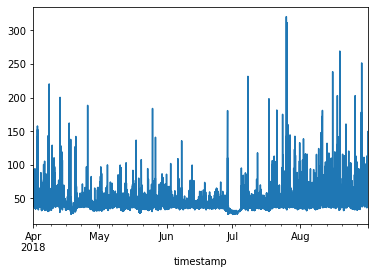

In [26]:
use_data['sensor_45'].plot()

# Time-Series Selection Methods
- 특정 sensor와 가장 correlation이 높은 일부의 sensor를 뽑는다.
- subset sensor들을 통해 regression을 취한다.

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [152]:
def time_series_selection_method(df, target_col, shift_value=2, num_select_cols=2, train_size=0.7):  
    train_data, val_data = train_test_split(df, train_size=train_size, shuffle=False)
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    
    selected_cols = df.corr(method='pearson')[target_col].sort_values(ascending=False)[0:num_select_cols+1].index.to_list()
    for col in selected_cols:
        for i in range(0,shift_val+1):
            if (col != target_col) and (i == 0):
                continue
            else:
                train_df['shift' + str(col) + str(i) ] = train_data[col].shift(i)
                val_df['shift' + (col) + str(i)] = val_data[col].shift(i)
            
    train_df.dropna(axis=0, inplace=True)
    val_df.dropna(axis=0, inplace=True)
    model = LinearRegression()
    print(train_df.drop('shift'+str(target_col)+'0', axis=1).columns)
    model.fit(train_df.drop('shift'+str(target_col)+'0', axis=1), train_df['shift'+str(target_col)+'0'])
    train_pred = model.predict(train_df.drop('shift'+str(target_col)+'0', axis=1))
    val_pred = model.predict(val_df.drop('shift'+str(target_col)+'0', axis=1))

    return train_pred, val_pred

In [153]:
train_pred, val_pred = time_series_selection_method(use_data, 'sensor_40', shift_value=3, num_select_cols=3, train_size=0.7)

Index(['shiftsensor_401', 'shiftsensor_402', 'shiftsensor_403',
       'shiftsensor_431', 'shiftsensor_432', 'shiftsensor_433',
       'shiftsensor_421', 'shiftsensor_422', 'shiftsensor_423',
       'shiftsensor_461', 'shiftsensor_462', 'shiftsensor_463'],
      dtype='object')


<function matplotlib.pyplot.show(*args, **kw)>

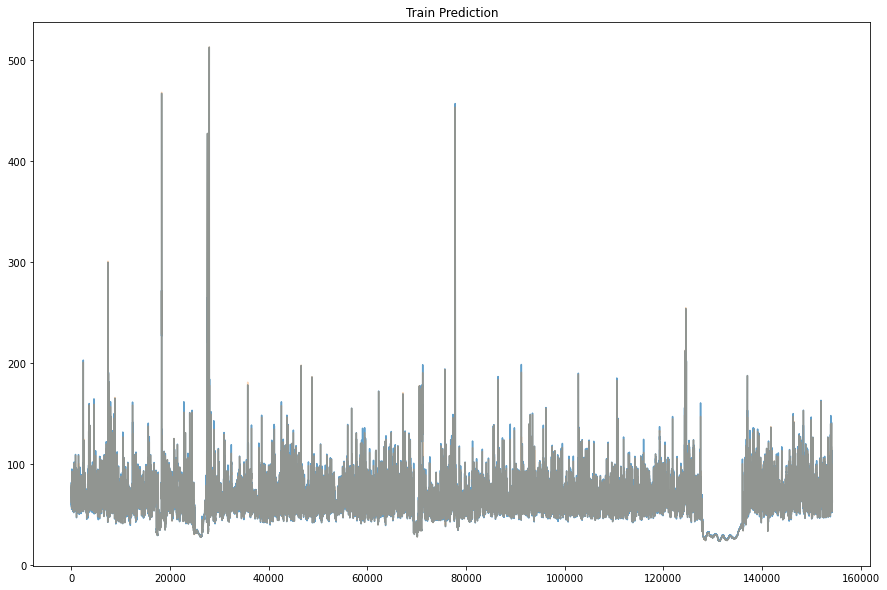

In [143]:
plt.figure(figsize=(15,10))
plt.title('Train Prediction')
plt.plot(train_pred, alpha=0.7)
plt.plot(list(use_data['sensor_40'][2:len(train_pred)]), alpha=0.3)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

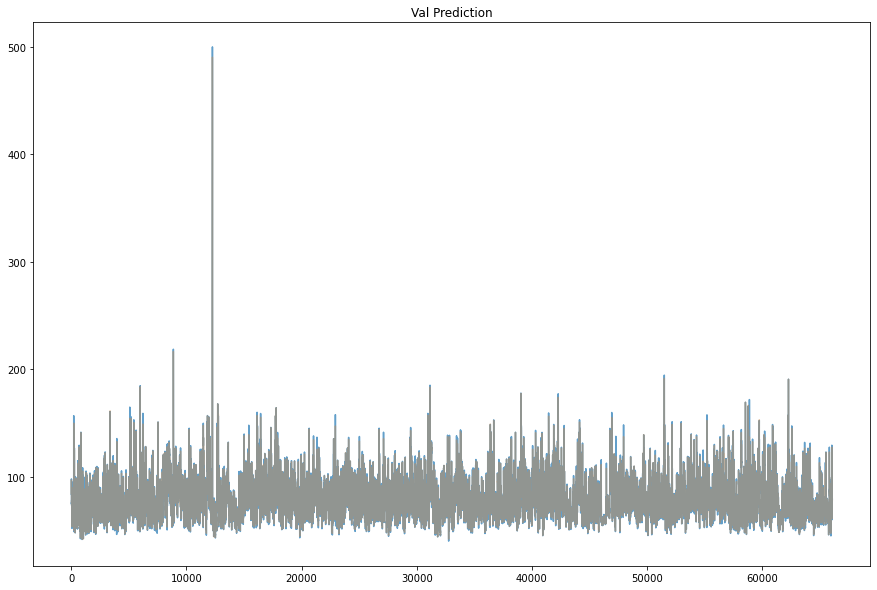

In [144]:
plt.figure(figsize=(15,10))
plt.title('Val Prediction')
plt.plot(val_pred, alpha=0.7)
plt.plot(list(use_data['sensor_40'][-len(val_pred):]), alpha=0.3)
plt.show

## Anomaly score (in `sensor_40`)

In [145]:
val_df = pd.DataFrame()
val_df['val_pred'] = val_pred
val_df['val_real'] = use_data['sensor_40'][-len(val_pred):].to_list()
val_df['machine_status'] = use_data['machine_status'][-len(val_pred):].to_list()

In [146]:
outlier_score = val_df['val_real'] - val_df['val_pred']
val_df['outlier_score'] = outlier_score

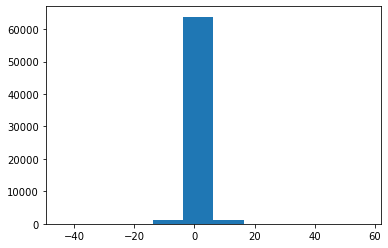

In [147]:
plt.hist(val_df['outlier_score'])
plt.show()

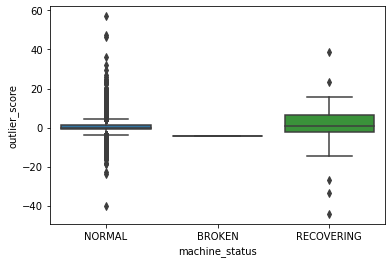

In [149]:
import seaborn as sns
sns.boxplot(val_df['machine_status'], val_df['outlier_score'])

- 예측이 잘되서 anomaly score가 거의 0에 수렴한다.
- `machine_status`를 봐도 `NORMAL`의 경우가 anomaly score가 큰 경우가 더 많은 듯 하다.
- 이상치로 보이지만 예측이 가능 하다면? 이상치가 아닌가?

# PCA and Hidden Variable-Based Models
- 원래 p개의 multiple time series data가 있다고 한다면
- PCA를 통해 d(<p)개로 축소한다.
- 각각 univariate time series prediction을 한다.
- 다시 p개로 복원한다.
- 각 p개의 time series마다 outlier score를 계산할 수 있다.
    - 이를 원하는 대로 이용하여 outlier를 찾는다.